# Model Training using GPU

In [ ]:
!pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4


In [ ]:
!pip install "jax[cuda11_cudnn86]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 10.6 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.4+cuda11.cudnn82
    Uninstalling jaxlib-0.4.4+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.4.4+cuda11.cudnn82


In [ ]:
!pip install jaxlib==0.4.6 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.4+cuda11.cudnn86
    Uninstalling jaxlib-0.4.4+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.4+cuda11.cudnn86


In [ ]:
!pip install -q ml-collections git+https://github.com/google/flax

/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
!pip install git+git://github.com/deepmind/optax.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/deepmind/optax.git to /tmp/pip-req-build-5ei3mjtr
  Running command git clone --filter=blob:none --quiet git://github.com/deepmind/optax.git /tmp/pip-req-build-5ei3mjtr


In [ ]:
!pip install git+https://github.com/deepmind/dm-haiku

## Optional: Connect to Google Cloud so that you can use Google Bucket

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

In [ ]:
# !echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
# !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
# !apt -qq update
# !apt -qq install gcsfuse

After this you can mount Google Cloud Bucket. However, it is usually required to to convert everything to tf.record so that TPU can be fully utilized. We will not discuss this here. 

## Use GPU to train a custom neural network
--------------------------------------------
Here we will use a GPU to train a custom neural network. This is majorly to simplify things. Typically, it is strongly recommend to ``copy'' source codes, typically written in PyTorch, so that no mistakes are made. 

In [ ]:
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

def get_datasets(num_epochs, batch_size):
  """Load MNIST train and test datasets into memory."""
  train_ds = tfds.load('mnist', split='train')
  test_ds = tfds.load('mnist', split='test')

  train_ds = train_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                           tf.float32) / 255.,
                                          'label': sample['label']}) # normalize train set
  test_ds = test_ds.map(lambda sample: {'image': tf.cast(sample['image'],
                                                         tf.float32) / 255.,
                                        'label': sample['label']}) # normalize test set

  train_ds = train_ds.repeat(num_epochs).shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
  test_ds = test_ds.shuffle(1024) # create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
  test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1) # group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency

  return train_ds, test_ds

In [ ]:
from flax import linen as nn  # Linen API

class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

In [ ]:
import jax
import jax.numpy as jnp  # JAX NumPy

cnn = CNN()
print(cnn.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 28, 28, 1))))


                                  CNN Summary                                   
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs            ┃ outputs           ┃ params            ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│         │ CNN    │ float32[1,28,28,… │ float32[1,10]     │ Conv_0:           │
│         │        │                   │                   │   bias:           │
│         │        │                   │                   │ float32[32]       │
│         │        │                   │                   │   kernel:         │
│         │        │                   │                   │ float32[3,3,1,32] │
│         │        │                   │                   │ Conv_1:           │
│         │        │                   │                   │   bias:           │
│         │        │                   │                   │ float32[64]       │
│         │        │       

In [ ]:
!pip install -q clu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct                # Flax dataclasses
import optax    

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
  accuracy: metrics.Accuracy
  loss: metrics.Average.from_output('loss')

In [ ]:
class TrainState(train_state.TrainState):
  metrics: Metrics

def create_train_state(module, rng, learning_rate, momentum):
  """Creates an initial `TrainState`."""
  params = module.init(rng, jnp.ones([1, 28, 28, 1]))['params'] # initialize parameters by passing a template image
  tx = optax.sgd(learning_rate, momentum)
  return TrainState.create(
      apply_fn=module.apply, params=params, tx=tx,
      metrics=Metrics.empty())

In [ ]:
@jax.jit
def train_step(state, batch):
  """Train for a single step."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
    return loss
  grad_fn = jax.grad(loss_fn)
  grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state

In [ ]:
@jax.jit
def compute_metrics(*, state, batch):
  logits = state.apply_fn({'params': state.params}, batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']).mean()
  metric_updates = state.metrics.single_from_model_output(
    logits=logits, labels=batch['label'], loss=loss)
  metrics = state.metrics.merge(metric_updates)
  state = state.replace(metrics=metrics)
  return state

In [ ]:
num_epochs = 10
batch_size = 32

train_ds, test_ds = get_datasets(num_epochs, batch_size)

INFO:absl:Load dataset info from /root/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/root/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /root/tensorflow_datasets/mnist/3.0.1
INFO:absl:Load dataset info from /root/tensorflow_datasets/mnist/3.0.1
INFO:absl:Fields info.[citation, splits, supervised_keys, module_name] from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset mnist (/root/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /root/tensorflow_datasets/mnist/3.0.1
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
tf.random.set_seed(0)
init_rng = jax.random.PRNGKey(0)

In [ ]:
learning_rate = 0.01
momentum = 0.9

In [ ]:
state = create_train_state(cnn, init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [ ]:
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

In [ ]:
metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

In [ ]:
for step,batch in enumerate(train_ds.as_numpy_iterator()):

  # Run optimization steps over training batches and compute batch metrics
  state = train_step(state, batch) # get updated train state (which contains the updated parameters)
  state = compute_metrics(state=state, batch=batch) # aggregate batch metrics

  if (step+1) % num_steps_per_epoch == 0: # one training epoch has passed
    for metric,value in state.metrics.compute().items(): # compute metrics
      metrics_history[f'train_{metric}'].append(value) # record metrics
    state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

    # Compute metrics on the test set after each training epoch
    test_state = state
    for test_batch in test_ds.as_numpy_iterator():
      test_state = compute_metrics(state=test_state, batch=test_batch)

    for metric,value in test_state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)

    print(f"train epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['train_loss'][-1]}, "
          f"accuracy: {metrics_history['train_accuracy'][-1] * 100}")
    print(f"test epoch: {(step+1) // num_steps_per_epoch}, "
          f"loss: {metrics_history['test_loss'][-1]}, "
          f"accuracy: {metrics_history['test_accuracy'][-1] * 100}")

train epoch: 1, loss: 0.20328359305858612, accuracy: 93.89167022705078
test epoch: 1, loss: 0.09214771538972855, accuracy: 96.85496520996094
train epoch: 2, loss: 0.05933733284473419, accuracy: 98.211669921875
test epoch: 2, loss: 0.05388956144452095, accuracy: 98.37740325927734
train epoch: 3, loss: 0.038979422301054, accuracy: 98.92666625976562
test epoch: 3, loss: 0.04254426434636116, accuracy: 98.70793151855469
train epoch: 4, loss: 0.02964738756418228, accuracy: 99.11666870117188
test epoch: 4, loss: 0.03969377651810646, accuracy: 98.76802825927734
train epoch: 5, loss: 0.02272186055779457, accuracy: 99.34500122070312
test epoch: 5, loss: 0.035254813730716705, accuracy: 98.91827392578125
train epoch: 6, loss: 0.01826229877769947, accuracy: 99.50167083740234
test epoch: 6, loss: 0.03341476991772652, accuracy: 98.87820434570312
train epoch: 7, loss: 0.01412136573344469, accuracy: 99.61666870117188
test epoch: 7, loss: 0.032658033072948456, accuracy: 99.0284423828125
train epoch: 8, 

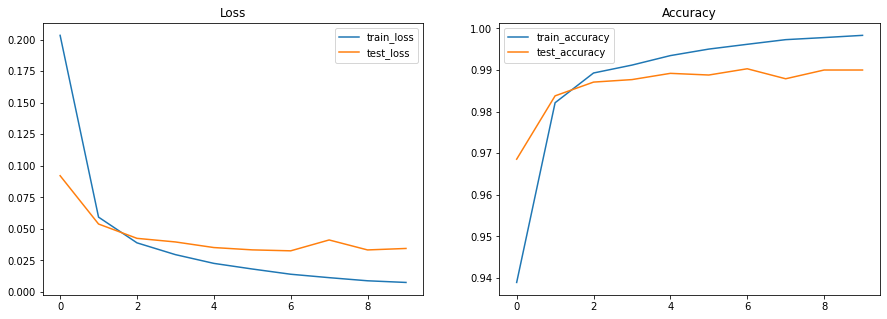

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

In [ ]:
@jax.jit
def pred_step(state, batch):
  logits = state.apply_fn({'params': state.params}, test_batch['image'])
  return logits.argmax(axis=1)

test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

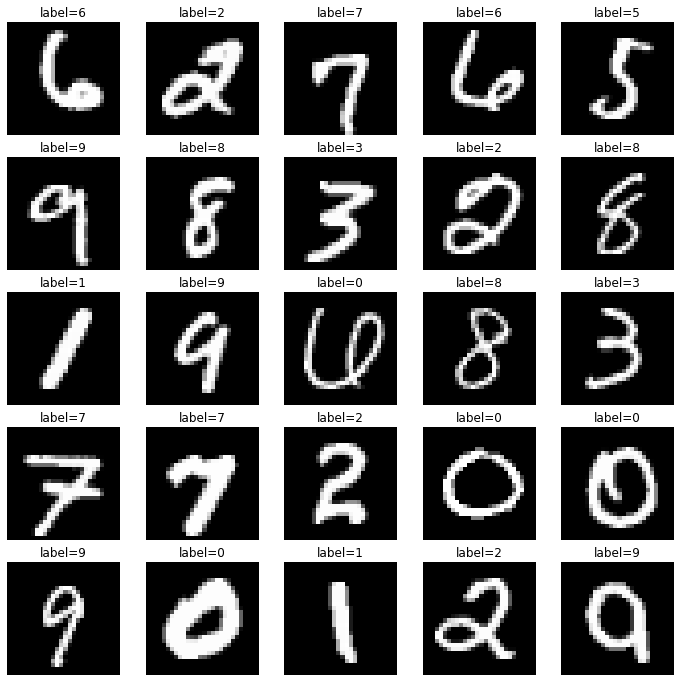

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
    ax.set_title(f"label={pred[i]}")
    ax.axis('off')